In [6]:
from opacus.optimizers.optimizer import _check_processed_flag, _mark_as_processed, DPOptimizer
from torch.distributions.laplace import Laplace
from torch.distributions.gamma import Gamma
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch import stack, zeros, einsum
from opacus.optimizers.utils import params
from torch import nn
from torch.optim import Optimizer
from scipy.stats import truncnorm, expon

class PLRVDPOptimizer():
    """
    Implementation of PLRV first noise mechanism.
    """
        
    def make_noise(self, args):
        self.args = args
        self.k = self.args['k']
        self.theta = self.args['theta']
        self.mu = self.args['mu']
        self.sigma = self.args['sigma']
        self.a = self.args['a']
        self.b = self.args['b']
        self.l = self.args['l']
        self.u = self.args['u']
        self.clip = self.args['max_grad_norm']
        self.lam = self.args['lam']
        
        a_transformed, b_transformed = (self.l - self.mu) / self.sigma, (self.u - self.mu) / self.sigma
        
        self.gamma = Gamma(
          concentration = self.k, rate = self.theta
          )
        self.normal= truncnorm(
          a_transformed, b_transformed, loc=self.mu, scale=self.sigma
          )
        self.uniform = Uniform(
          low = self.a, high = self.b
          )
        self.expon = expon(loc=0, scale = 1/self.lam)
    
    
    def add_noise(self):
          
        for p in self.params:
            _check_processed_flag(p.summed_grad)
            
            laplace = self.get_laplace()
            noise = laplace.sample(p.summed_grad.shape).to(p.summed_grad.device)
            p.grad = p.summed_grad + noise

            _mark_as_processed(p.summed_grad)
            
    def get_linear_combination(self):
        gam = self.gamma.sample()
        uni = self.uniform.sample()
        t_norm = self.normal.rvs(size=1)[0]  
        exp = self.expon.rvs(size=1)[0]
        return 1/(self.args['a1']*gam+self.args['a3']*exp+self.args['a4']*uni)
        
    def get_laplace(self):
        return Laplace(loc=0, scale=self.get_linear_combination())
        
    def clip_and_accumulate(self):
        """
        Performs gradient clipping.
        Stores clipped and aggregated gradients into `p.summed_grad```
        """

        if len(self.grad_samples[0]) == 0:
            # Empty batch
            per_sample_clip_factor = zeros(
                (0,), device=self.grad_samples[0].device
            )
        else:
            per_param_norms = [
                g.reshape(len(g), -1).norm(1, dim=-1) for g in self.grad_samples
            ]
            per_sample_norms = stack(per_param_norms, dim=1).norm(1, dim=1)
            per_sample_clip_factor = (
                self.max_grad_norm / (per_sample_norms + 1e-6)
            ).clamp(max=1.0)

        for p in self.params:
            _check_processed_flag(p.grad_sample)
            grad_sample = self._get_flat_grad_sample(p)
            grad = einsum("i,i...", per_sample_clip_factor, grad_sample)

            if p.summed_grad is not None:
                p.summed_grad += grad
            else:
                p.summed_grad = grad

            _mark_as_processed(p.grad_sample)

In [7]:
args ={
            "a1":0.3,
            "a3":0.6,
            "a4":0.1,
            "lam":5,
            "moment":1,
            "theta":3,
            'k':1,
            'mu':0,
            'sigma':0.1,
            'a':0,
            'b':2,
            'u':1,
            'l':0.1,
            'epsilon':1,
            'max_grad_norm': 1,
        }

In [8]:
noise = PLRVDPOptimizer()
noise.make_noise(args)
laplace = noise.get_laplace()
laplace.sample((1,1000)).tolist()[0]

import matplotlib.pyplot as plt
samples = []
for i in range(1000):
    laplace = noise.get_laplace()
    samples.append(laplace.sample().tolist())
    
print(samples)

[-0.9970875382423401, -0.39940693974494934, 0.16799317300319672, -0.37548038363456726, 0.10100827366113663, 0.10291291773319244, -1.007584810256958, -0.17013713717460632, -0.205534428358078, -0.12788523733615875, -0.8085377216339111, 0.41810908913612366, 0.2644226849079132, -0.09363598376512527, -0.04577798768877983, 1.1157511472702026, 0.7680634260177612, -0.9027631282806396, 0.15679596364498138, 0.16283881664276123, -0.36882284283638, 0.03611442446708679, 0.8281835913658142, -0.2340501993894577, 0.09367472678422928, 0.3681900203227997, 0.2890472412109375, 0.1586879938840866, -0.013555646874010563, 0.33681365847587585, -0.4172396659851074, 0.48292630910873413, -0.02584397979080677, -0.3333781063556671, 0.3931517004966736, -0.2299126535654068, -0.3700394630432129, 0.05223575979471207, 0.5703334808349609, -0.1157412976026535, 0.07962515950202942, 0.40732452273368835, 0.37774553894996643, 0.21278543770313263, 0.015136071480810642, -0.37070417404174805, 0.612159252166748, -0.1900219917297

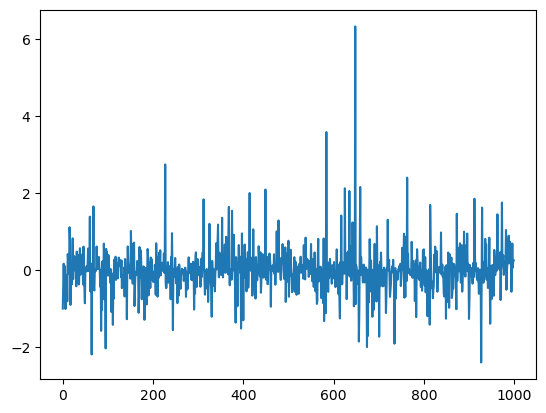

In [9]:
plt.plot(range(1000), samples)
plt.show()